<h1>Training and evaluating ML models for phishing</h1>

## Introduction
To choose an effective model for our use case we will run an investigation into the performance of three different machine learning models on our datasets. These models will utilise external validation to gain a clearer indication on their generalisation abilities, we will use Dataset A (phishtank_extracted_features.csv) and Dataset B (final_kaggle_dataset.csv). The models will be trained on A, validated with B and vice versa. The models used in our investigation will be standard classification models, namely Random Forest, XGBoost and Logistic Regression and Naive Bayes. This is a combination of simpler and more complex models.

### Logistic Regression
Logistic Regression is a standard ML classification model used to calculate binary classification tasks. This method analyses the relationship between one or more independent variables and utilises the logistic function to map y as a sigmoid function of x. The strength of logistic regression lies in its simplicity, offering greater interpretability and not being a 'black box'. This applies particularly well to this project, as the model can relay the weights of features to the chatbot to effectively inform the user behind its decision, leading to greater learning for the user. This interpretability can also lead to greater understanding between certain features and their significance with phishing.

### Naive Bayes
The main concept behind Naive Bayes is to utilise the Bayes' Theorem to classify data based on probability. Features within the model are assumed to be independent of all other features, meaning each feature contributes to the prediction without relation to others. This algorithm is already widely used in spam filtration models, meaning applying it to phishing detection may allow for a logical transition.

### Random Forest
Random Forest is another supervised learning algorithm, the core aspect of this model is to create decision trees and combine them into a 'forest'. The underlying logic is that multiple uncorrelated models, the trees, perform better as a group than as a solitary model. Each tree gains a 'vote' which is the classification that is selected, these votes are then compiled and the classification with the majority vote is chosen. The reasoning for choosing this particular model is the in-built measures for preventing overfitting, allowing for generalisation. Continuing on this, the algorithm is efficient, which is useful for reacting quickly to user actions. Finally, it is also very interpretable with the utilisation of SHAP values, which can explain the reasoning behind decisions.

### XGBoost
XGBoost stands for Extreme Gradient Boosting, which is an implementation of a gradient-boosted decision tree. Similar to Random Forest, it is an ensemble learning algorithm, meaning that it combines various weak algorithms together to form a strong decision-making entity. Gradient boosting is the process of generating weak models over a descending gradient on an objective function, aiming to create a less error-prone model each generation. The benefits of this model are similar to Random Forest.


### Dataset Description
Dataset A: 43602 samples, 55.247% phishing and 44.753% benign

Dataset B: 10462 samples, 52.992% phishing and 47.008% benign

Feature Count: 15




## Setup
We can now set up to train our models, we will load the necessary libraries and datasets.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.model_selection import  train_test_split, learning_curve
from sklearn.metrics import  confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve


# Explainability
import shap


In [62]:
phishA = pd.read_csv("Datasets/Final_datasets/extracted_phishtank_features.csv")
kaggleB = pd.read_csv("Datasets/Final_datasets/final_kaggle_data.csv")

### Evaluation Functions
The functions used to evaluate the model scores and plot graphs will be created here.

In [184]:
def appendScores(model, X_test, y_test): #create array of scores for each model performance
    y_pred = model.predict(X_test)
    scores = {}
    scores['Accuracy'] = model.score(X_test,y_test)
    scores['F1 Score'] = f1_score(y_test, y_pred)
    scores['Precision'] = precision_score(y_test, y_pred)
    scores['Recall'] = recall_score(y_test, y_pred)
    try:
        scores['ROC AUC:'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    except AttributeError:
        # Some models might not have predict_proba method
        scores['ROC AUC:'] = "Not available"
    return pd.DataFrame([scores])


def getScores(model, internal_test_featuresX, internal_test_labely, external_featuresX, external_labely ): #create function to get both internal and external scores, then append to the array
    internal_scores = appendScores(model, internal_test_featuresX, internal_test_labely)
    internal_scores.index = ['Internal']

    external_scores = appendScores(model, external_featuresX, external_labely)
    external_scores.index = ['External']
    df = pd.concat(
        [internal_scores, external_scores]
    )
    display(df)

In [64]:
def getConfusionMatrices(model, internal_test_featuresX, internal_test_labely, external_featuresX, external_labely):
    # Predict labels for both datasets
    internal_test_pred = model.predict(internal_test_featuresX)
    external_pred = model.predict(external_featuresX)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    cm_internal = confusion_matrix(internal_test_labely, internal_test_pred)
    cm_external = confusion_matrix(external_labely, external_pred)
    sns.heatmap(cm_internal, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    sns.heatmap(cm_external, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    plt.tight_layout()

In [65]:
def plotROC(model, X_test, y_test, bX, by): # Plot ROC curve for a given model
    y_probs = model.predict_proba(X_test)[:, 1]
    by_probs = model.predict_proba(bX)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    bfpr, btpr, bthresholds = roc_curve(by, by_probs)
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(fpr, tpr)
    axes[0].set_title("Internal ROC")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[1].plot(bfpr, btpr)
    axes[1].set_title("External ROC")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    plt.tight_layout()

In [178]:
def plot_learning_curves(model, title, X, y): #plot learning curves for each model for better evaluation
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=8, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="orange")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid()
    plt.tight_layout()
    plt.show()

### Setting up pipelines and data
We will use pipelines to ensure that scaling is applied correctly for each model and reduce chance of error when testing. This can be done using the sklearn Pipeline function.

In [186]:
aX = phishA.drop(columns=['phishing'])
ay = phishA['phishing']
bX = kaggleB.drop(columns=['phishing'])
by = kaggleB['phishing']
# Maybe move this up into the setup thing, add all the pipelines here and use this throughout the section.
logregA = Pipeline([('standardscaler', StandardScaler()), ('logrega', LogisticRegression(max_iter=1000, random_state=42))])
logregB = Pipeline([('standardscaler', StandardScaler()), ('logregb', LogisticRegression(max_iter=1000, random_state=42))])
randforestA = Pipeline([('randomforesta', RandomForestClassifier(n_estimators=100, random_state=42))])
randforestB = Pipeline([('randomforestb', RandomForestClassifier(n_estimators=100, random_state=42))])
naivebayesA = Pipeline([('standardscaler',StandardScaler()), ('naivebayesa', GaussianNB())])
naivebayesB = Pipeline([('standardscaler',StandardScaler()), ('naivebayesb', GaussianNB())])
xgboostA = Pipeline([('xgba', XGBClassifier(eval_metric='logloss', random_state=42))
])
xgboostB = Pipeline([('xgbb', XGBClassifier(eval_metric='logloss', random_state=42))])

The dataset will also be separated at an 8:2 split, saving 20% of the data as testing data.

In [83]:
aX_train, aX_test, ay_train, ay_test = train_test_split(aX, ay, test_size=0.2, random_state=42)
bX_train, bX_test, by_train, by_test = train_test_split(bX, by, test_size=0.2, random_state=42)

### Training models
Models will be trained here and tested during the evaluation

In [188]:
logregA = logregA.fit(aX_train, ay_train) #fit all models at the start for easier processing
logregB = logregB.fit(bX_train, by_train)
randforestA = randforestA.fit(aX_train, ay_train)
randforestB = randforestB.fit(bX_train, by_train)
naivebayesA = naivebayesA.fit(aX_train, ay_train)
naivebayesB = naivebayesB.fit(bX_train, by_train)
xgboostA = xgboostA.fit(aX_train, ay_train)
xgboostB = xgboostB.fit(bX_train, by_train)

## Models: A → B

### Logistic Regression

In [92]:
getScores(logregA, aX_test, ay_test, bX, by)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.878913,0.891291,0.888729,0.893867,0.944273
External,0.547696,0.662867,0.510200,0.945913,0.761742


At a glance, it can be seen that the accuracy drastically drops when utilised on unseen data. Despite the features and methods remaining the same, all indicators drop significantly. Precision in particular drops massively, meaning the rate of false positives increases dramatically. Recall however increases, indicating there are fewer false negatives, which may be useful for phishing detection as the cost of a false negative is high. The F1 score and lower accuracy may be caused by high false positives.

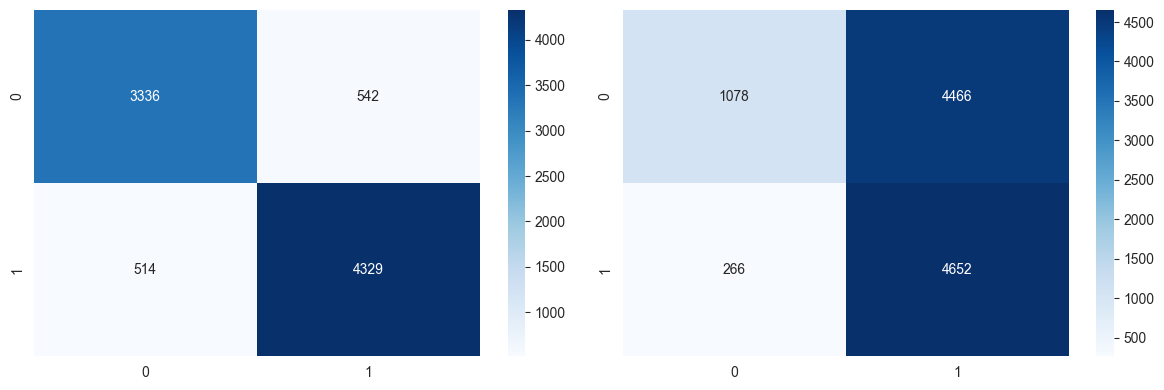

In [93]:
getConfusionMatrices(logregA, aX_test, ay_test, bX, by)

As visualised in the confusion matrices, the number of phishing URLs detected increases which is promising for the security aspect of this project. However, the false positive rate increases dramatically. We can also visualise the different thresholds for false positives with the ROC curve. The current ROC AUC score is above 0.5, indicating it is performing at a decent rate.

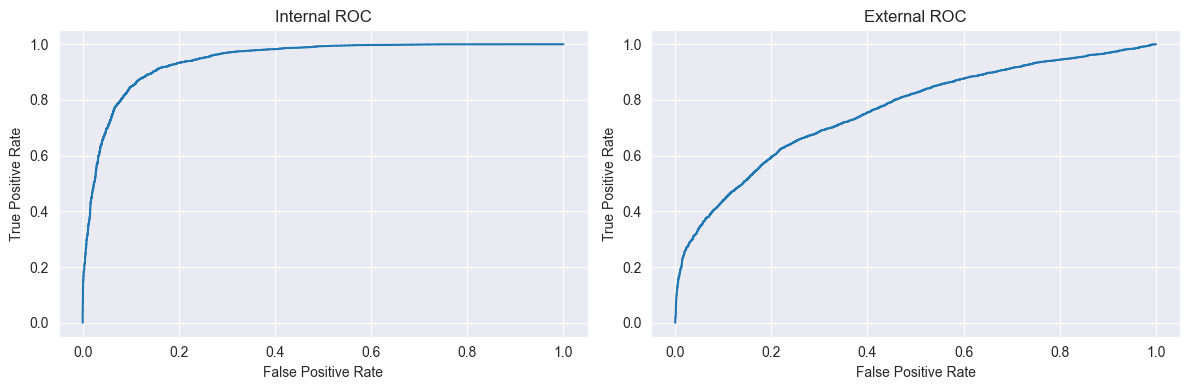

In [94]:
plotROC(logregA, aX_test, ay_test, bX, by)

### Naive Bayes

In [95]:
getScores(naivebayesA, aX_test, ay_test, bX, by)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.637656,0.538686,0.919283,0.380962,0.905557
External,0.591952,0.463221,0.606919,0.374542,0.427039


The Naive Bayes model performs considerably worse, with a ROC AUC score indicating it could be choosing classifications randomly. It underperforms on the internal dataset as well as the external set.

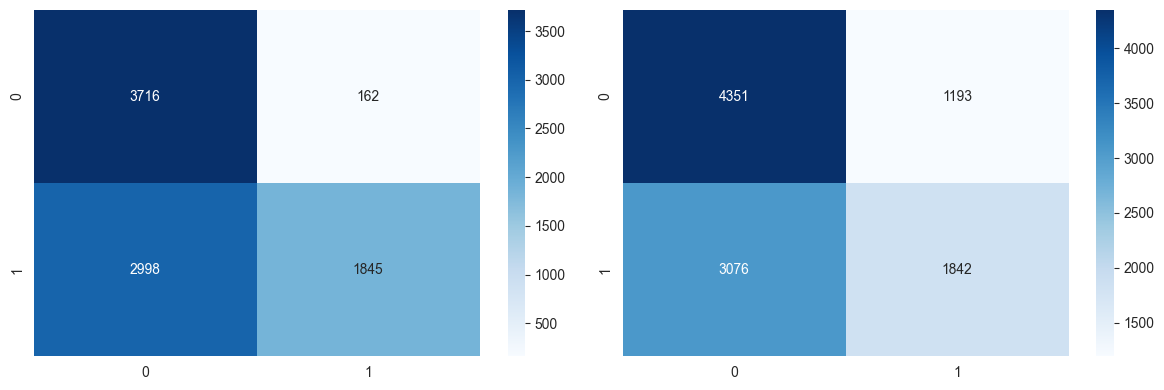

In [96]:
getConfusionMatrices(naivebayesA, aX_test, ay_test, bX, by)

As visualised in the confusion matrices, a high number of true phishing URLs are being falsely denoted as benign, which is unacceptable for this use-case.

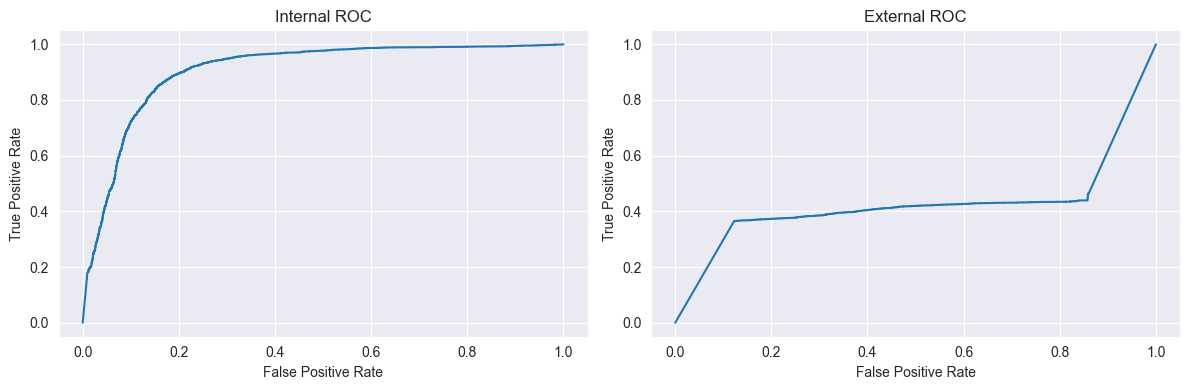

In [97]:
plotROC(naivebayesA, aX_test, ay_test, bX, by)

The ROC graphs also show that when dealing with external URLs it is not performing, meaning unseen URLs that will be encountered in the usage of this model will be incorrectly classified.

### Random Forest

In [98]:
getScores(randforestA, aX_test, ay_test, bX, by)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.927302,0.935333,0.924209,0.946727,0.977538
External,0.713917,0.738031,0.647918,0.857259,0.827339


The Random Forest model is performing quite well on unseen data and internal data. The high scores on internal data may be evidence of overfitting, but the performance on external data far exceeds that of the Naive Bayes and Logistic Regression models. It maintains a high recall score, indicating false negatives are kept to a minimum, important for our purpose. Precision seems to take the largest fall in performance, however still outperforming the previous models.

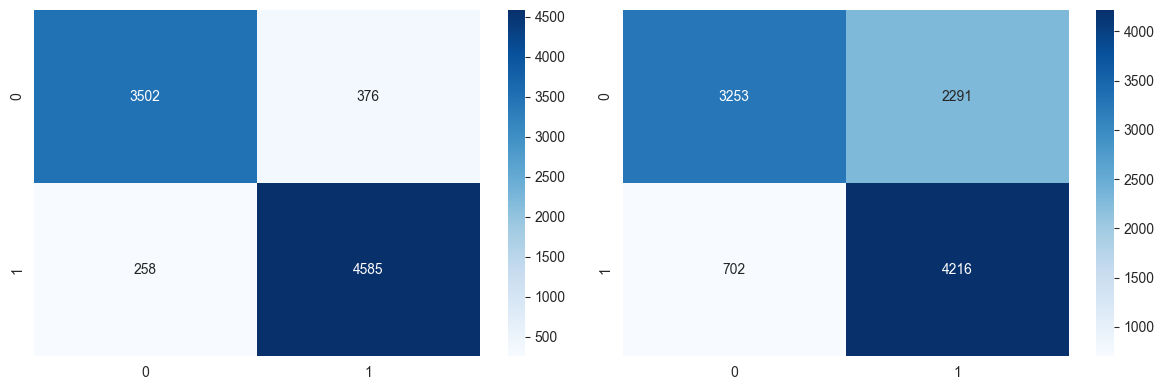

In [99]:
getConfusionMatrices(randforestA, aX_test, ay_test, bX, by)

The confusion matrices show that it performs well on internal data, but on external data it loses performance in terms of false positives and a minor effect on detecting actual phishing URLs

### XGBoost

In [100]:
getScores(xgboostA, aX_test, ay_test, bX, by)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.933150,0.940174,0.934517,0.945901,0.982224
External,0.744026,0.745340,0.700071,0.796869,0.830918


This model is more balanced than the Random Forest model, as it maintains a higher rate of precision on unseen data. It also outperforms the Random Forest model on internal data, with higher accuracy and precision, which are needed, however the recall drops. This would indicate a higher number of phishing URLs are being falsely classified.

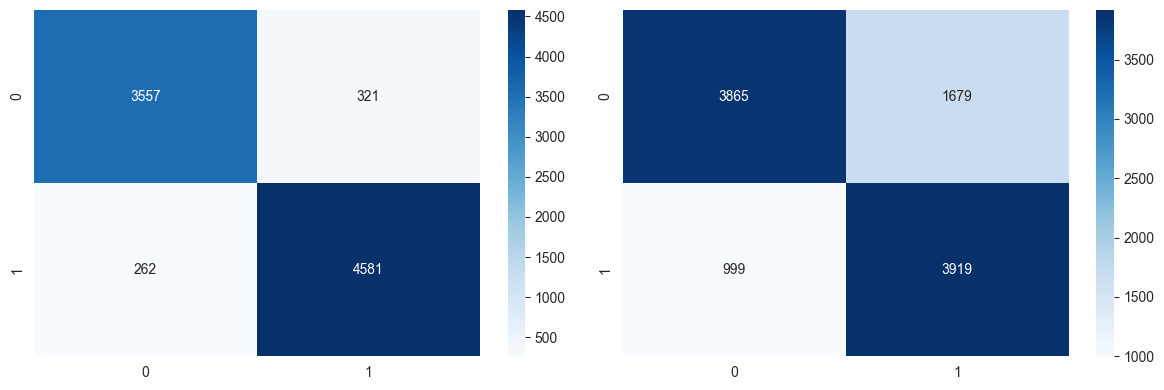

In [101]:
getConfusionMatrices(xgboostA, aX_test, ay_test, bX, by)

As shown here, whilst the number of false positives is not as high, the detection for malicious URLs does drop.

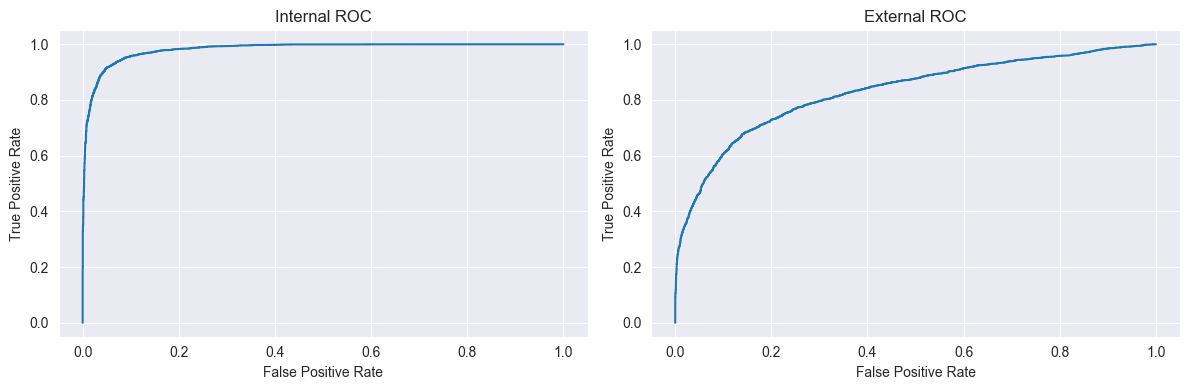

In [102]:
plotROC(xgboostA, aX_test, ay_test, bX, by)

## Models: B → A
### Logistic Regression

In [103]:
getScores(logregB, bX_test, by_test, aX, ay)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.87291,0.864286,0.879543,0.849549,0.931858
External,0.51782,0.228647,0.983896,0.129354,0.839607


Training on dataset B creates a model that performs worse in all metrics, with a noticeable drop in external recall. This is unsuitable for this project.

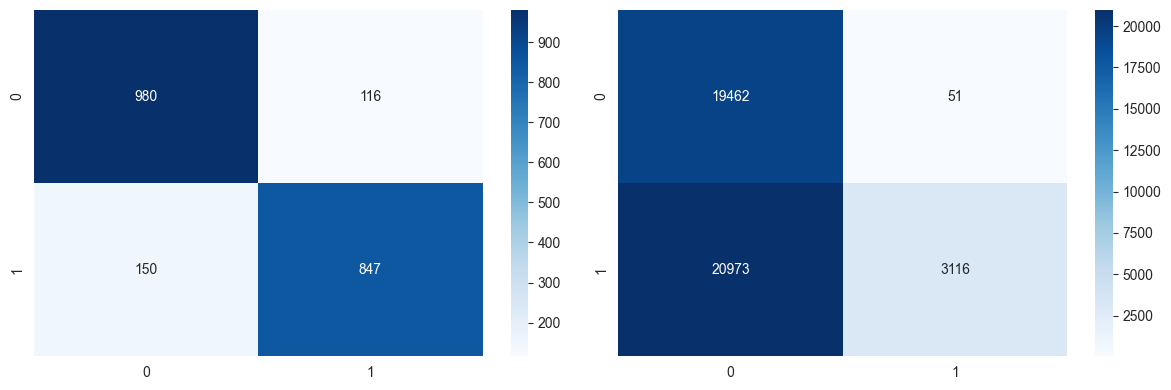

In [104]:
getConfusionMatrices(logregB, bX_test, by_test, aX, ay)

As seen above, the number of false negatives increases dramatically when looking at unseen data. This could be a byproduct of the evolution of phishing, as dataset B is from 2021, with considerable changes to common techniques.

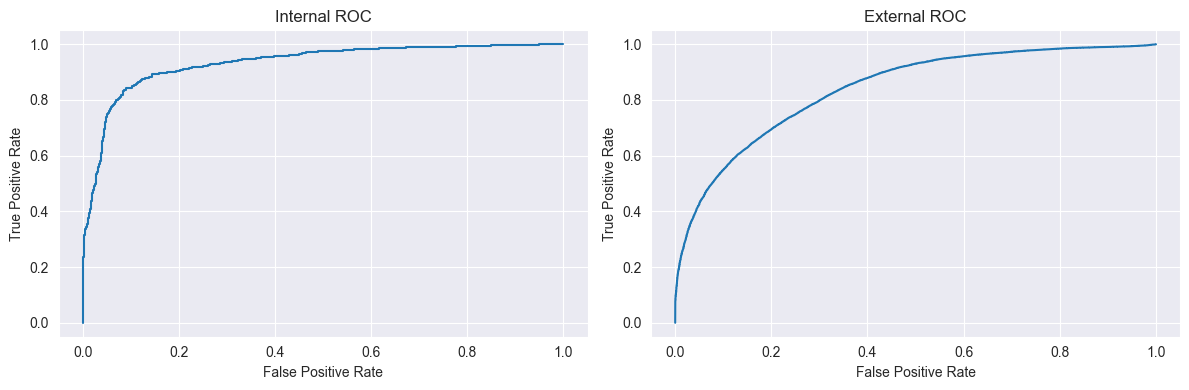

In [105]:
plotROC(logregB, bX_test, by_test, aX, ay)

The ROC graphs do indicate that the model is not performing randomly, indicating it could be learning incorrectly.

### Naive Bayes

In [106]:
getScores(naivebayesB, bX_test, by_test, aX, ay)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.649785,0.427791,0.964789,0.274824,0.906593
External,0.522247,0.240991,0.985399,0.137283,0.627486


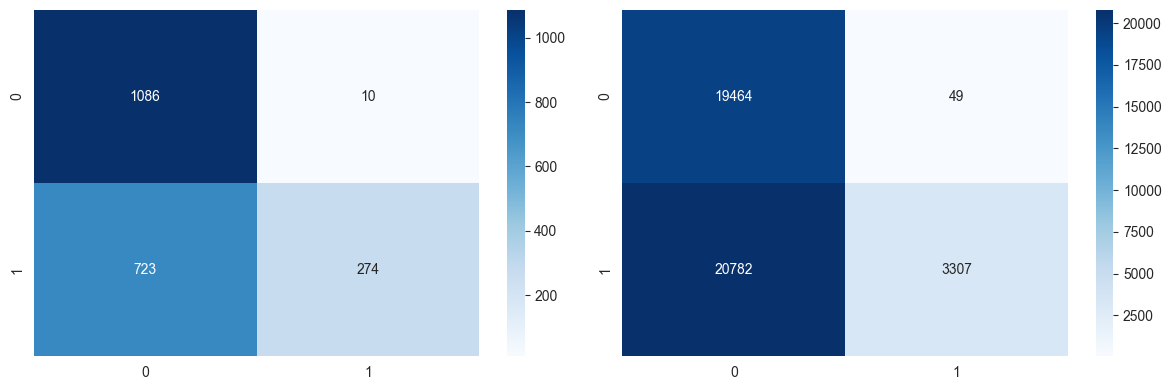

In [107]:
getConfusionMatrices(naivebayesB, bX_test, by_test, aX, ay)

Naive Bayes performs exceedingly worse when trained on dataset B. While the number of false positives is low, the number of false negatives is unacceptably high. This model is unsuitable for this project.

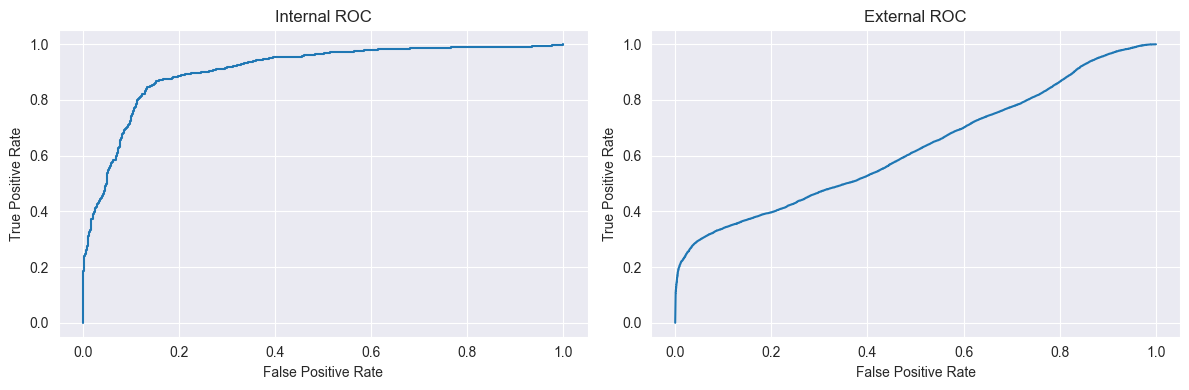

In [108]:
plotROC(naivebayesB, bX_test, by_test, aX, ay)

While the model doesn't seem to be performing randomly as indicated by the AUC score, it still maintains a low true positive rate

### Random Forest

In [110]:
getScores(randforestB, bX_test, by_test, aX, ay)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.933588,0.930045,0.933333,0.926780,0.98077
External,0.566167,0.376943,0.912454,0.237536,0.82399


The Random Forest model shows a significant decrease in performance on unseen data, most noticeably on recall. With a recall score this low, the number of phishing URLs would be lacking, indicating this model is not fit for this project.

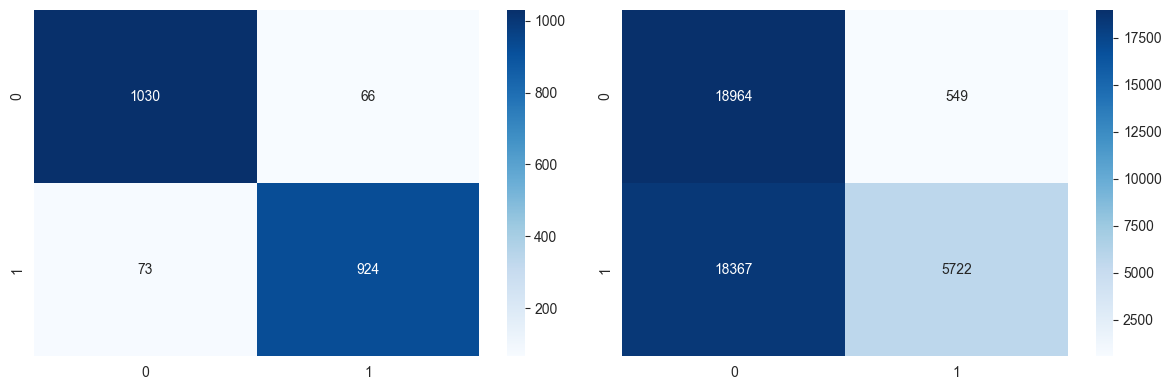

In [111]:
getConfusionMatrices(randforestB, bX_test, by_test, aX, ay)

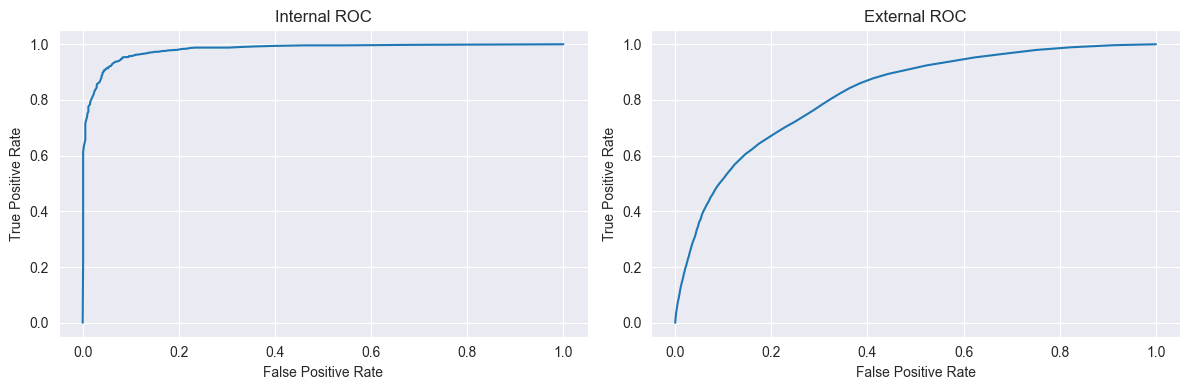

In [112]:
plotROC(randforestB, bX_test, by_test, aX, ay)

The matrices show that there is a substantial increase in false negatives, while the ROC curve does show that the model seemingly doesn't perform randomly. This could again be due to the age of the dataset.

### XGBoost

In [114]:
getScores(xgboostB, bX_test, by_test, aX, ay)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.938366,0.934551,0.945585,0.923771,0.980749
External,0.607541,0.486866,0.876769,0.337000,0.744273


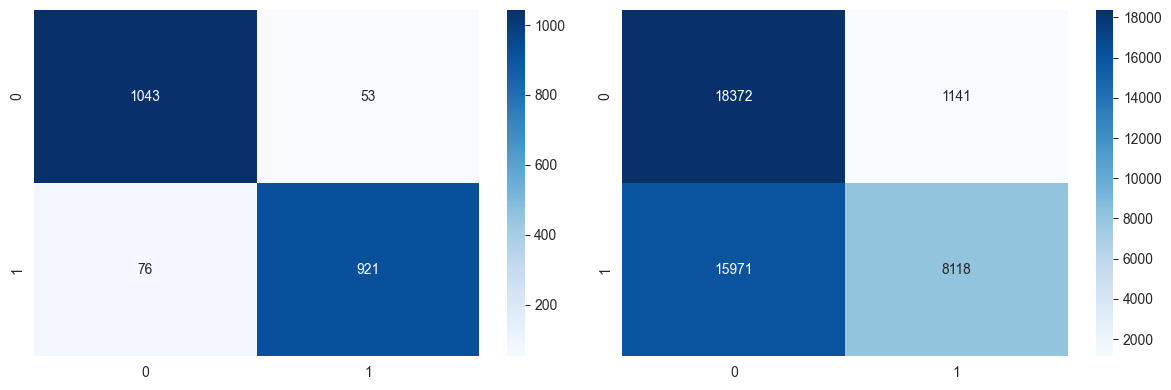

In [115]:
getConfusionMatrices(xgboostB, bX_test, by_test, aX, ay)

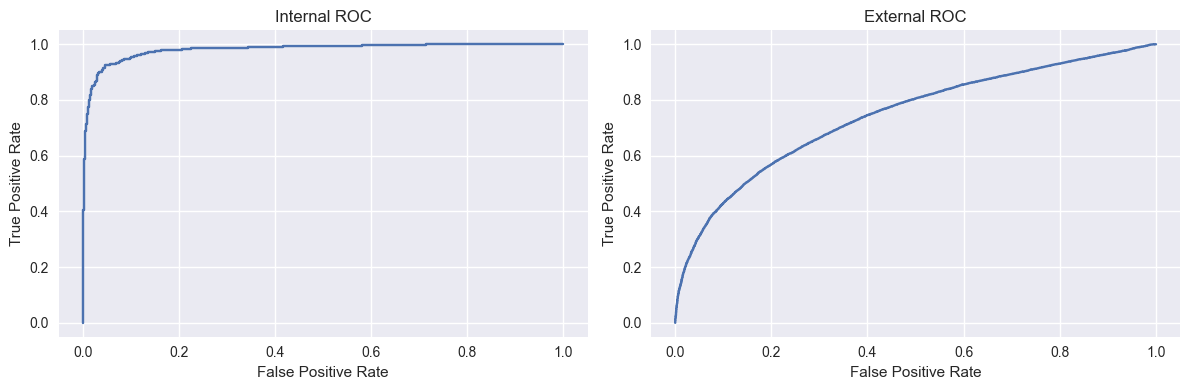

In [176]:
plotROC(xgboostB, bX_test, by_test, aX, ay)

The XGBoost model also underperforms when compared to its counterpart trained on dataset A, with the ROC score indicating it does not perform randomly whilst also suffering a drop in all metrics, with the recall dropping significantly.

## Further Evaluation

Throughout this comparison, it became increasingly clear that models trained on dataset B consistently underperformed when presented with unseen data, whilst still performing well internally. This could be a symptom of a greater shift in phishing techniques, as the age of the dataset may have correctly captured URLs some years ago. New techniques however may present these models with great difficulty, as relatively modern URLs are consistently mislabelled as safe. This could also be a discrepancy in the size of the dataset, as the modern dataset contains roughly 5 times as many items.

However, after evaluating all models, the decision tree-based models, XGBoost and Random Forest, seem the most promising. Whilst the logistic regression (A) model had a high rate of recall, the extremely high false positive would prove alarming to users. Despite this, further evaluation is required on XGBoost and Random Forest before hyperparameter tuning, namely exploring the potential of overfitting and understanding how each model arrives at it's conclusion. The suspicion of overfitting comes from a drop in F1 scores from 0.83 to 0.73 (Random Forest) and 0.94 to 0.74 (XGBoost).

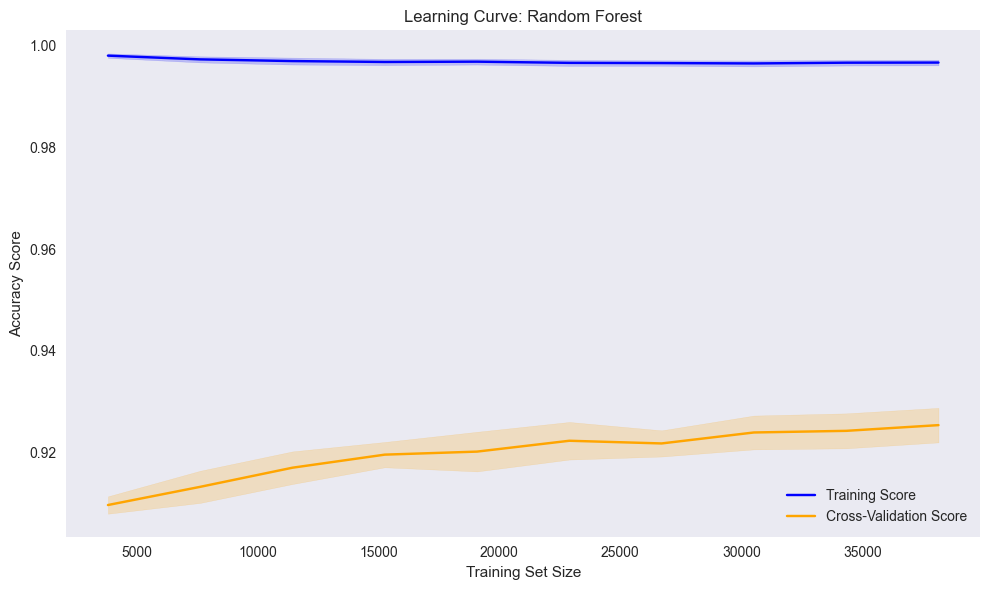

In [179]:
# Plot learning curves for Random Forest and XGBoost
plot_learning_curves(RandomForestClassifier(random_state=42), "Learning Curve: Random Forest", aX, ay)

The learning curve for Random Forest does show signs of potential overfitting. Whilst the score for the training data is slowly reducing, indicating that the model learns as more data is added, the rate at which it does so is quite slow. However, the validation score increases as the training set increases in size, indicating that adding further training data may allow the model to generalise well with the addition of even more data. This would be useful for future iterations of the model, as more data could be added to increase performance further.

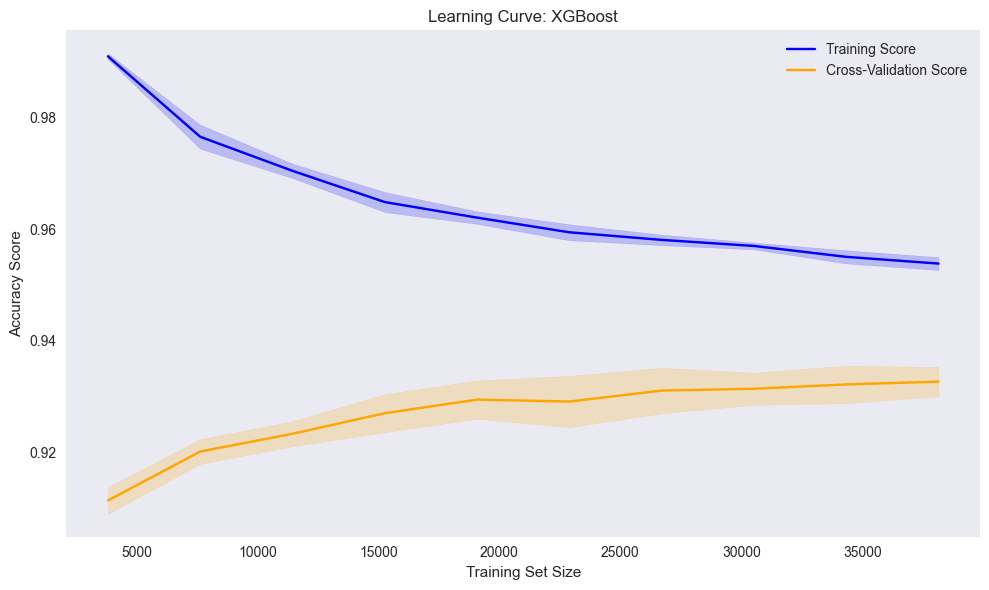

In [180]:
plot_learning_curves(XGBClassifier(eval_metric='logloss', random_state=42), "Learning Curve: XGBoost", aX, ay)

The learning curve for XGBoost shows promise, as the scores of the validation and training sets converge. Indicating that the model is learning to generalise and thus would be appropriate for the use case. The declining training score also shows that overfitting is a low possibility.

<h3> Ensemble Learning </h3>
Due to the performance of XGBoost and Random Forest, ensemble learning was also considered. Below are the scores of a model utilising both tree models as estimators and XGBoost as a final estimator due to literature?????

In [164]:
from sklearn.ensemble import StackingClassifier

rf = randforestA
xgb = xgboostA
lga = logregA

stack_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
    ],
    final_estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    cv=8
)

stack_model.fit(aX_train, ay_train)

StackingClassifier(cv=8,
                   estimators=[('rf',
                                Pipeline(steps=[('randomforest',
                                                 RandomForestClassifier(random_state=42))])),
                               ('xgb',
                                Pipeline(steps=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric='...
                                                 feature_weights=None,
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None, ...))

In [165]:
getScores(stack_model, aX_test, ay_test, bX, by)

,Accuracy,F1 Score,Precision,Recall,ROC AUC:
Internal,0.930742,0.937911,0.933879,0.941978,0.981020
External,0.746607,0.747114,0.703684,0.796259,0.827543


As shown this is promising. Precision noticeably doesn't drop as much as it did in just Random Forest, however recall also drops. Which is important to this project. This ensemble model may perform better with different hyperparameters so that will have to be examined.